# Run BMA on Background Galaxies

In this notebook, I edited the copa functions in order to run BMA on background galaxies using their true redshift.

In [60]:
import esutil
import numpy as np
import h5py
import os

In [84]:
import matplotlib.pyplot as plt

# Auxialiary Functions

In [ ]:
def check_not_hf5(hf,path):
    return path not in hf.keys()

def delete_group(fname,path):
    fmaster = h5py.File(fname,'a')
    try:
        group   = fmaster[path]
    except:
        fmaster.close()
        return

    cols = group.keys()
    if len(cols)>0:
        for col in cols: del group[col]
    fmaster.close()
    
def stack_dict(in_list):
    columns = list(in_list[0].keys())
    new_dict= dict().fromkeys(columns)
    for col in columns:
        res = [mydict[col] for mydict in in_list]
        new_dict[col] = np.concatenate(res)
    return new_dict

def read_hdf5_file_to_dict(file,cols=None,indices=None,path='/'):
    hf = h5py.File(file, 'r')
    
    mygroup = hf[path]

    if cols is None: cols  = list(mygroup.keys())
    if indices is None: indices = np.arange(0,len(mygroup[cols[0]]),1,dtype=np.int64)

    mydict= dict().fromkeys(cols)
    for col in cols:
        mydict[col] = mygroup[col][:][indices]
    
    hf.close()

    return mydict
def write_bma_dict_temp_files(files,table,nsize,nchunks):
    columns = table.keys()
    idxs    = np.linspace(0,nsize,nchunks+1,dtype=np.int64)
    
    for i,file in enumerate(files):
        if not os.path.isfile(file):
            hf = h5py.File(file,'w')
            hf.create_group('bma')
            for col in columns:
                ilo,iup = idxs[i],idxs[i+1]
                hf.create_dataset('bma/%s/'%col,data=table[col][ilo:iup])
            hf.close()
    return files

# Loading the master file

In [167]:
mfile = '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/cosmoDC2_v1.1.4_copa.hdf5'

In [164]:
h=0.7
def make_bma_catalog_cut(fname,zmin=0.1,zmax=1.,rin=4,rout=6,dz=0.05,dmag_lim=0.,h=0.7):
    fmaster = h5py.File(fname, "a")

    ## check if bma already exists
    if check_not_hf5(fmaster['members'],'bma_bkg'):
        print('making bma cutout')
        columns = fmaster['members/main']
        radii   = fmaster['members/main/R'][:]*h
        dmag    = fmaster['members/main/dmag'][:]
        zoff    = fmaster['members/main/zoffset'][:]
        mid     = fmaster['members/main/mid'][:]
        z       = fmaster['members/main/z_true'][:]

        #cut,    = np.where((radii<=rmax)&(dmag<=dmag_lim))
        mask  = (z<=zmax)&(z>=zmin)
        mask &= (radii<=rout)&(radii>=rin)
        mask &= (np.abs(zoff)<=dz)
        cut   = np.where(mask)[0]
        try: fmaster.create_group('members/bma_bkg/')
        except: print('group already exists')
            
        fmaster.create_dataset('members/bma_bkg/mid/', data=mid[cut])
        fmaster['members/bma_bkg/'].attrs['rout'] = rout
        fmaster['members/bma_bkg/'].attrs['rin']  = rin
        fmaster['members/bma_bkg/'].attrs['zmin'] = zmin
        fmaster['members/bma_bkg/'].attrs['zmax'] = zmax
        fmaster['members/bma_bkg/'].attrs['dmag'] = dmag_lim
        fmaster['members/bma_bkg/'].attrs['nsize'] = int(cut.size)
    else:
        print('BMA cut already exists; overwrite=False')
        fmaster.close()
        delete_group(mfile,'members/bma_bkg/')
        #make_bma_catalog_cut(fname,zmin=zmin,zmax=zmax,rin=rin,rout=rout,dz=dz,dmag_lim=dmag_lim)
        
    bma_indices = fmaster['members/bma_bkg/mid/'][:]
    fmaster.close()
    return bma_indices

In [168]:
indices = make_bma_catalog_cut(mfile,zmin=0.1,zmax=1.,rin=5.75,rout=6.,dz=0.05,dmag_lim=0.)

making bma cutout
group already exists


In [170]:
indices.size/100

3674

In [183]:
def make_bma_input_temp_file(fname,files,indices,nsize,nchunks):
    mcols       = ['mid','CID','z_true','mag','magerr','Mr']                ## master/main/ columns
    out_columns = ['mid','CID','redshift','i','ierr','gr','ri','iz','grerr','rierr','izerr']
    
    if not os.path.isfile(files[0]):
        mydict = read_hdf5_file_to_dict(fname,indices=indices,cols=mcols,path='members/main/')

        out= dict().fromkeys(out_columns)
        for col in mcols:
            out[col] = mydict[col][:]
        
        out['indices'] = np.arange(0,out['mid'].size,1,dtype=np.int64)

        out['i']    = mydict['mag'][:,2]
        out['ierr'] = mydict['magerr'][:,2]

        out['gr']   = mydict['mag'][:,0] - mydict['mag'][:,1]
        out['ri']   = mydict['mag'][:,1] - mydict['mag'][:,2]
        out['iz']   = mydict['mag'][:,2] - mydict['mag'][:,3]

        out['grerr']= np.sqrt(mydict['magerr'][:,0]**2 + mydict['magerr'][:,1]**2)
        out['rierr']= np.sqrt(mydict['magerr'][:,1]**2 + mydict['magerr'][:,2]**2)
        out['izerr']= np.sqrt(mydict['magerr'][:,2]**2 + mydict['magerr'][:,3]**2)
        
        out['redshift'] = mydict['z_true']
        write_bma_dict_temp_files(files,out,nsize,nchunks)
    return out

In [185]:
fname = mfile
nsize  = indices.size
nchunks= 100

root  = os.path.dirname(mfile)
bma_temp_input_files  = [root+'temp_file/bkg_input_{:05d}.hdf5'.format(i+1) for i in range(nchunks)]
bma_temp_output_files = [root+'temp_file/bkg_output_{:05d}.hdf5'.format(i+1) for i in range(nchunks)]

data = make_bma_input_temp_file(mfile,bma_temp_input_files,indices,nsize,nchunks)

In [173]:
bma_temp_input_files

['/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs//temp_file/bkg_input_00001.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs//temp_file/bkg_input_00002.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs//temp_file/bkg_input_00003.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs//temp_file/bkg_input_00004.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs//temp_file/bkg_input_00005.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs//temp_file/bkg_input_00006.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs//temp_file/bkg_input_00007.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs//temp_file/bkg_input_00008.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs//temp_file/bkg_input_00009.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs//temp_file/bkg_input_00010.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs//temp_file/bkg_input_00011.hdf5',
 '/data/de

# Visualizing the input sample

In [180]:
data

{'CID': array([ 91600026411,  91600026411,  91600026411, ..., 102000186338,
        102000186338, 102000186338]),
 'Mr': array([-21.38117 , -20.044697, -18.567278, ..., -20.867363, -20.10088 ,
        -19.536366], dtype=float32),
 'gr': array([1.13479424, 0.84538269, 1.05239105, ..., 1.61550903, 0.93707848,
        1.35031891]),
 'grerr': array([0.00666416, 0.02346434, 0.04170643, ..., 0.10027803, 0.06970059,
        0.19854481]),
 'i': array([18.01560726, 20.23461514, 20.80471928, ..., 21.13563352,
        21.67952703, 22.39036397]),
 'ierr': array([0.00399152, 0.01580468, 0.02324518, ..., 0.02921337, 0.04279864,
        0.07117561]),
 'indices': array([     0,      1,      2, ..., 367443, 367444, 367445]),
 'iz': array([0.29990005, 0.26721573, 0.25525856, ..., 0.39838219, 0.18682289,
        0.25603676]),
 'izerr': array([0.00617117, 0.02434872, 0.03723495, ..., 0.04484057, 0.08019943,
        0.1504043 ]),
 'mag': array([[19.65122547, 18.51643124, 18.01560726, 17.71570721],
        

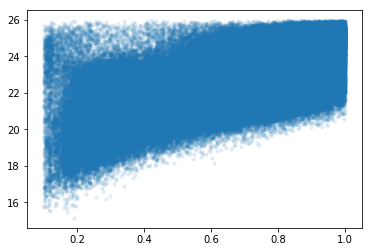

In [181]:
plt.scatter(data['z_true'],data['i'],s=10,alpha=0.1)

# Running BMA

In [194]:
from joblib import Parallel, delayed
import sys

sys.path.append('/home/s1/jesteves/git/ccopa/python/bma')
import smass

def bma_trigger(infiles,outfiles,inPath,
               nCores=2,batchStart=0,batchEnd=None,overwrite=False):
    if batchEnd is None: batchEnd = self.bma_nchunks

    batches = np.arange(batchStart,batchEnd,1,dtype=np.int64)

    print('starting parallel process')
    print('runing on the following batches:',batches)
    Parallel(n_jobs=nCores)(
        delayed(smass.calc_copa_v2)(infiles[i], outfiles[i], inPath) for i in batches)
    print('ended smass calc')

In [ ]:
nCores = 51
libPath= '/data/des61.a/data/pbarchi/galaxyClusters/simha_miles_Nov2016/'
bma_trigger(bma_temp_input_files, bma_temp_output_files, libPath,
            nCores=nCores,batchStart=0,batchEnd=nchunks)

starting parallel process
('runing on the following batches:', array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))


# Saving as a Fits File

In [ ]:
from astropy.table import Table, vstack, join

def combine_hdf5_files(files,path='/'):
    """ Combine hdf5 files with same data structure
    """
    mylist = []
    count  = 0
    for file in files:
        if os.path.isfile(file):
            mydict = read_hdf5_file_to_dict(file,path=path)
            mylist.append(mydict)
        else:
            print('missing the temp file: %s'%(file))
            count+=1

    all_dict=stack_dict(mylist)
    return all_dict, count

In [ ]:
table, nmissing = combine_hdf5_files(bma_temp_output_files,path='bma/')

In [ ]:
new_indices = table['mid'][:]
out_data   = Talbe(table)

In [ ]:
mcols       = ['mid','stellar_mass','CID','GID','RA','DEC','mag','magerr','R','dmag','z_true','zoffset']  ## master/main/ columns
mydict      = read_hdf5_file_to_dict(mfile,indices=new_indices,cols=mcols,path='members/main/')
data        = Table(mydict)

In [ ]:
bma_data = join(out_data,data,keys=['mid'])

In [ ]:
outfile = root+'/cosmoDC2_v1.1.4_bma_bkg_ztrue.fits'
bma_data.write(outfile,format='fits',overwrite=True)

# Removing temp files

In [ ]:
def remove_files(files):
    for file in files:
        os.remove(file)

In [ ]:
#remove_files(bma_temp_input_files)
#remove_files(bma_temp_output_files)